# Main figure for the paper with downstream analysis - CID4465

In this notebook, we present the main downstream analysis to explore the impact of cellular niche and cellular composition on cell type specific gene expression. Here, we show the mapping, the spatial selection of the cells, the differences in GEx patterns, exploration of DEGs, differences in colocalization and cell-cell communication. Moreover, we orgnize the notebook as the main figure of the paper. 

In [1]:
global_path = './cell-cell-communication/' ## Path to the github downloaded repository

In [2]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pickle
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import random
import ktplotspy as kpy
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

from sklearn.metrics import roc_curve, roc_auc_score, auc,fbeta_score, precision_score
from scipy.spatial.distance import pdist, cdist
from scipy.spatial import distance
from scipy.stats import spearmanr


import sys
sys.path.insert(1, global_path + 'Functions/')
from process_visium import visium_noh5
from mapping_exploration import prepare_cytospace, abundances_figure
from downstream_analysis import pseudoreplicates, obtain_deg, compute_colocalization, run_cellphonedb
plt.rcParams['font.family'] = 'FreeSans' 
from adjustText import adjust_text
title_size = 12
labelout_size = 10
label_size = 8
ticks_size = 6

patient = 'CID4465'


In [3]:
### breast cancer slide and metadata
main_path_exp = global_path + 'Data/Breast/spatial_data/filtered_count_matrices/CID4465_filtered_count_matrix/'
main_path_spatial = global_path + 'Data/Breast/spatial_data/spatial/CID4465_spatial/'
library_id = 'breast_tissue'
adata_vis = visium_noh5(main_path_exp, main_path_spatial, library_id) 
meta_patho = pd.read_csv(global_path+'Data/Breast/spatial_data/metadata/CID4465_metadata.csv') ## metadata with spot annotation

### breast cancer anndata current patient filtered
adata_ref = sc.read(global_path+'Data/Breast/normalized_log.h5ad')
adata_ref = adata_ref[adata_ref.obs.Patient == 'CID4465']


# Figure 1A: Representation of spatial mapping - CytoSPACE

Here we are representing the spatial distribution of the main cell types across the slide. We first use the `prepare_cytospace` function from the `/Functions/prepare_data_abundances.py` to extract the counts per spots of this cell types and save the coordinates of this spots for representation. Then we use the `abundances_figure` to represent where each specific cell type is located in the space. For representation purposes, we normalize the abundance values and select the most abundant cell per spot. 

In [4]:
cytospace_folder = global_path + 'Results/Breast/CytoSPACE/CID4465/'
## Select the cells that you want to visualize in the space
query_cells = ['Cancer', 'T', 'CAFs', 'Macrophage']
## Compute abundances 
abundances, coords = prepare_cytospace(cytospace_folder, query_cells)

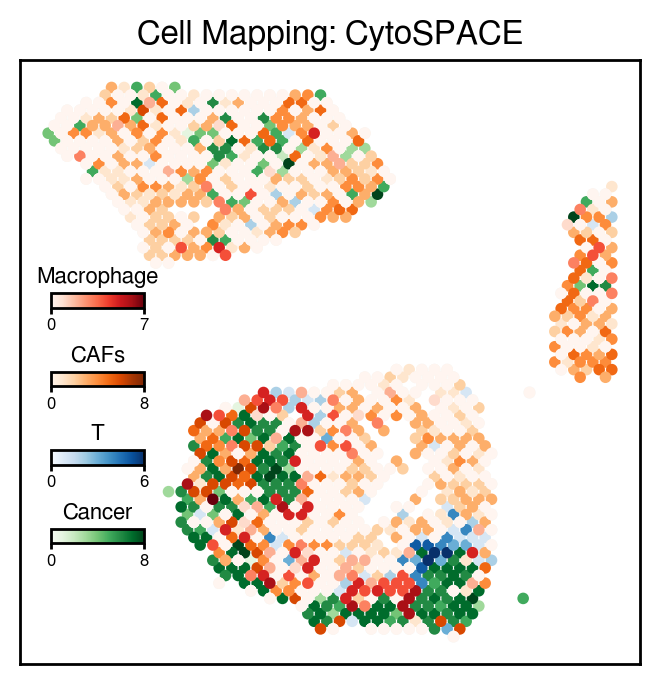

In [5]:
## Inicialize figure
fig, ax_scatter = plt.subplots(figsize=(4, 4), dpi=200)

## Define colorbar bounds
colorbar_bounds = [
    [0.05, 0.1+0.1, 0.15, 0.024],  # Bottom right corner, first column
    [0.05, 0.23+0.1, 0.15, 0.024],   # Second row
    [0.05, 0.36+0.1, 0.15, 0.024],  # First column, one row above
    [0.05, 0.49+0.1, 0.15, 0.024],   # Second row
]
## Figure
abundances_figure(abundances, coords, ax_scatter, query_cells, 'Cell Mapping: CytoSPACE', colorbar = True, colorbar_bounds = colorbar_bounds)



# Categorize selected cell type into distinct groups based on their spatial position

Once we have explore the mapping result, we can select a cell type of interest, in our case **Cancer cells** and identify distinct spatial regions to assign these cells, and explore how variations in cellular composition affect the gene expression of the cell of interest and communication dynamics. 

<ipython-input-6-51e01a33e198>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


([], [])

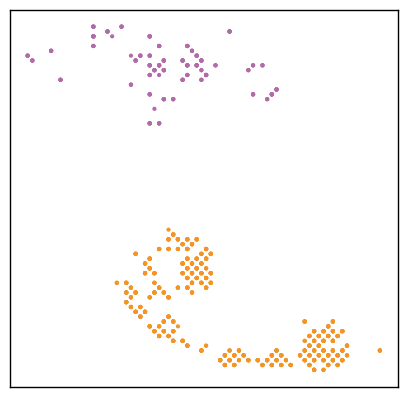

In [6]:
## output CytoSPACE 
cyto_cell2spot = pd.read_csv(cytospace_folder + 'assigned_locations.csv') # Each individual cell assigned to which spot
cyto_spot2cell = pd.read_csv(cytospace_folder + 'cell_type_assignments_by_spot.csv') # For each spot, which cells types are assigned to it (quantity)
del(cyto_spot2cell['Total cells']) ## remove total cells column

cancer_cell2spot = cyto_cell2spot[cyto_cell2spot.CellType.str.contains('Cancer')]

## Assign to each mapped cell to a group according to the division of the sections (you have to do it manually)
colors = []
for i in cancer_cell2spot['UniqueCID']:
    c = cancer_cell2spot[cancer_cell2spot['UniqueCID'] == i]        
    if (c.row.values[0] >40 and c.col.values[0]<114):
        colors.append('#F39426')
    elif (c.row.values[0] < 30 and c.col.values[0]<100): 
        colors.append('#B16BA8')
    else: 
        colors.append('grey')

cancer_cell2spot['cluster'] = colors ### add to the metadata 
cancer_cell2spot = cancer_cell2spot[cancer_cell2spot['cluster'] != 'grey']


### Check the distribution of the cells in the space
fig = plt.subplots(figsize=(5, 5), dpi = 100)
plt.scatter(cancer_cell2spot.col, -cancer_cell2spot.row, color = cancer_cell2spot.cluster, s = 4)
plt.yticks([])
plt.xticks([])

In [7]:
## Subset the dataframe and split it into the two spatial groups
# select the cells according to the loc
cancer_loc1= cancer_cell2spot[cancer_cell2spot.cluster == '#B16BA8']
cancer_loc2 = cancer_cell2spot[cancer_cell2spot.cluster == '#F39426']

# remove the cells that are in both clusters (because cytoSPACE have been run allowing for the same cell to be in different spots)
list_repited = cancer_loc2[cancer_loc2.OriginalCID.isin(cancer_loc1.OriginalCID.tolist())].OriginalCID.unique()
cancer_cell2spot = cancer_cell2spot[~cancer_cell2spot.OriginalCID.isin(list_repited)]

# select again the df to dont count the repited cells
cancer_loc1= cancer_cell2spot[cancer_cell2spot.cluster == '#B16BA8']
cancer_loc2 = cancer_cell2spot[cancer_cell2spot.cluster == '#F39426']


Once we have defined the groups of cells based on spatial location, we can start with downstream analysis to explore differences in their GEx and communication dynamics

# Figure 1C: Distances between cancer cells in same locations vs different locations

Explore overall differences in GEx profiles in relation to cell spatial locations computing pairwise cosine distances between log-normalized GEx vectors.  

In [8]:
############## Select ids according to location ###############
# select the id of the cells according to the location and select a random background background
# We need to select the ids for obtaining the expression from the adata_ref
id_loc1 = cancer_cell2spot[cancer_cell2spot.cluster == '#B16BA8'].OriginalCID.unique()
id_loc2 = cancer_cell2spot[cancer_cell2spot.cluster == '#F39426'].OriginalCID.unique()
random_bk = np.random.choice(adata_ref.obs.index, len(cyto_cell2spot.OriginalCID.unique()), replace = False)

In [9]:
############# Distances according to location #############
# select the GEX of the spots
GEX_loc1 = adata_ref[adata_ref.obs.index.isin(id_loc1)].X.toarray()
GEX_loc2 = adata_ref[adata_ref.obs.index.isin(id_loc2)].X.toarray()
GEX_cancer = adata_ref[adata_ref.obs.index.isin(cancer_cell2spot.OriginalCID.unique())].X.toarray()
GEX_bk = adata_ref[adata_ref.obs.index.isin(random_bk)].X.toarray()

# calculate the distances
loc1_cosine = pdist(GEX_loc1, 'cosine')
loc2_cosine = pdist(GEX_loc2, 'cosine')
all_cosine = pdist(GEX_bk, 'cosine')
all_cosine_cancer = pdist(GEX_cancer, 'cosine')
vs_cosine = cdist(GEX_loc1, GEX_loc2, 'cosine')


In [10]:
print('Mean cosine distance between cancer cells in location 1: %s \nMean cosine distance between cancer cells in location 2: %s \nMean cosine distance between cells in diferent locations: %s'%(np.mean(loc1_cosine), np.mean(loc2_cosine), np.mean(np.concatenate(vs_cosine))))

Mean cosine distance between cancer cells in location 1: 0.6216949752092755 
Mean cosine distance between cancer cells in location 2: 0.539857527573322 
Mean cosine distance between cells in diferent locations: 0.5847610432160482


Text(0.5, 1.0, 'Distribution of GEx distances')

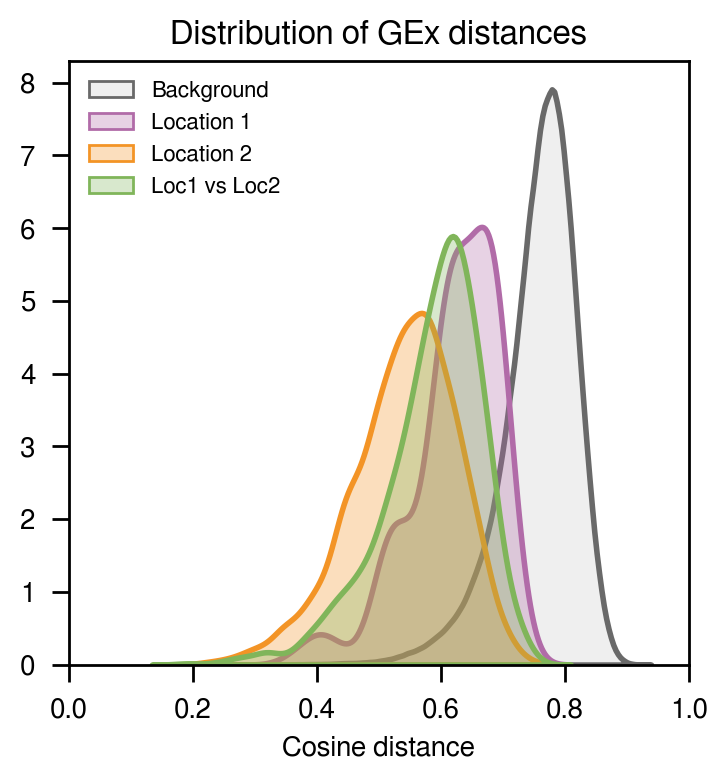

In [11]:

fig, axs = plt.subplots(figsize=(4, 4), dpi = 200)

sns.kdeplot(all_cosine, label = 'Background', color = 'dimgray', ax = axs, fill=True, alpha=.1,  linewidth=2)
sns.kdeplot(loc1_cosine, label = 'Location 1', color = '#B16BA8' ,ax = axs, fill=True, alpha=.3, linewidth=2)
sns.kdeplot(loc2_cosine, label = 'Location 2', color = '#F39426', ax = axs, fill=True,  alpha=.3,linewidth=2)
sns.kdeplot(np.concatenate(vs_cosine), label = 'Loc1 vs Loc2', color = '#80b55a', fill=True, alpha = 0.3,linewidth=2)


legend = axs.legend(frameon = False, fontsize = label_size, loc= 'upper left')
for handle in legend.legend_handles:
    handle.set_linewidth(1) 

axs.set_xlim(0,1)
axs.set_xlabel('Cosine distance', fontsize=labelout_size)
axs.set_ylabel('')
axs.tick_params(axis='both', which='major', labelsize=labelout_size)
axs.set_title('Distribution of GEx distances', fontsize=title_size)

We are not able to see differences between the groups at overall GEx level. But maybe we don't have enough resolution to see this differences 

# Figure 1D: Volcano plot

In [12]:
## Add cell group to the adata object
cell2cluster = dict(zip(cancer_cell2spot.OriginalCID, cancer_cell2spot.cluster)) # dict with the cell to group
adata_cancer = adata_ref[adata_ref.obs.index.isin(cancer_cell2spot.OriginalCID.tolist())] # subset the adata with only cancer cells mapped by cytoSPACE
adata_cancer.obs['cluster'] = [cell2cluster[i] for i in adata_cancer.obs.index] # add the cluster to the adata object

In [10]:
## Build the adata object for the pseudoreplicates
pb = pseudoreplicates(adata_cancer, 'cluster', n = 3)
## Obtain the DEG
loc1vsloc2 = obtain_deg(pb,'#B16BA8', '#F39426')

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.15 seconds.

Fitting dispersion trend curve...
... done in 4.10 seconds.

/home/epareja/miniconda3/envs/cpdb_v4/lib/python3.8/site-packages/pydeseq2/dds.py:619: RuntimeWarning: invalid value encountered in log
Fitting MAP dispersions...
... done in 7.08 seconds.

/home/epareja/miniconda3/envs/cpdb_v4/lib/python3.8/site-packages/pydeseq2/dds.py:687: RuntimeWarning: invalid value encountered in log
Fitting LFCs...
... done in 2.41 seconds.

Refitting 0 outliers.

Running Wald tests...


Log2 fold change & Wald test p-value: condition #B16BA8 vs #F39426
               baseMean  log2FoldChange     lfcSE      stat    pvalue   
FO538757.2     2.209473        0.076423  1.004574  0.076075  0.939360  \
AP006222.2     0.602706        1.226770  1.766490  0.694468  0.487389   
RP11-206L10.9  0.755866        0.437271  1.641837  0.266331  0.789985   
LINC00115      0.339928       -0.535627  2.119688 -0.252691  0.800507   
FAM41C         1.409668        0.841035  1.216949  0.691101  0.489502   
...                 ...             ...       ...       ...       ...   
RP11-366F6.2   0.659989        0.330397  2.064340  0.160050  0.872842   
MAGEA2B        0.050769        1.696994  4.430329  0.383040  0.701690   
LINC00837      0.302853        3.620568  4.430292  0.817230  0.413797   
SERPINB3       0.076603        1.697002  2.363514  0.717999  0.472758   
RP11-800A18.4  0.067976        1.696994  4.430329  0.383040  0.701690   

                   padj  
FO538757.2     0.998855  
AP00

... done in 0.91 seconds.



In [14]:
## Select significant DEGs adjusted p-value < 0.05 and log2FC > 1
loc1vsloc2.reset_index(inplace = True)
loc1vsloc2_sig = loc1vsloc2[loc1vsloc2.padj < 0.05]
loc1vsloc2_sig = loc1vsloc2_sig[abs(loc1vsloc2_sig.log2FoldChange) > 1]

No DEGs


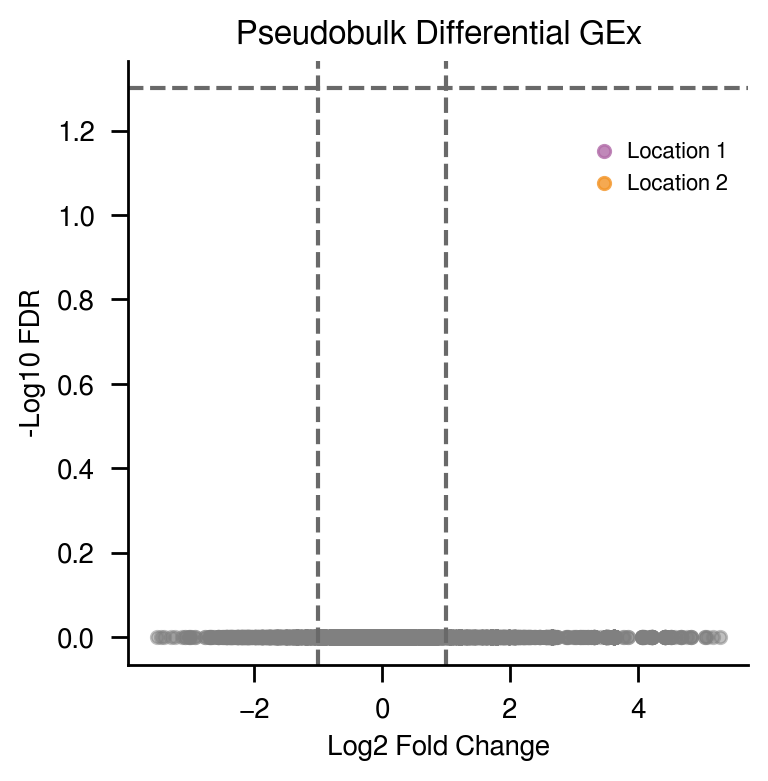

In [15]:
##### Select genes for the volcano plot text #####
# Select the top 5 up and down regulated genes 
top_dw = loc1vsloc2.sort_values('log2FoldChange').head(5)
top_up = loc1vsloc2.sort_values('log2FoldChange').tail(5)
top_all = top_dw.merge(top_up, how = 'outer')
# Select the genes with the lowest p-values
top_pval = loc1vsloc2_sig.sort_values('padj', ascending = True).head(10)

##### Create the volcano plot ####

# Transform data for plotting
log_fold_changes = loc1vsloc2.log2FoldChange.values      # Log2 fold change
neg_log_p_values = -np.log10(loc1vsloc2.padj.values)        # -Log10 p-value

fig = plt.figure(figsize=(4,4), dpi = 200)

# Scatter plot specifying points of interest
# Let's say significant points are those with abs(log fold change) > 1 and -log p-value > 1.5
plt.scatter(log_fold_changes, neg_log_p_values, color='grey', alpha=0.5, s = 20)
plt.scatter(log_fold_changes[(log_fold_changes > 1) & (neg_log_p_values > -np.log10(0.05))], 
            neg_log_p_values[(log_fold_changes > 1) & (neg_log_p_values > -np.log10(0.05))], 
            color='#B16BA8', alpha=0.8, s= 20, label = 'Location 1')

plt.scatter(log_fold_changes[(log_fold_changes < -1) & (neg_log_p_values > -np.log10(0.05))], 
            neg_log_p_values[(log_fold_changes < -1) & (neg_log_p_values > -np.log10(0.05))], 
            color='#F39426', alpha=0.8, s= 20, label = 'Location 2')

# Add gene names for the top genes
texts = []
for index, row in top_pval.iterrows():
        texts.append(plt.text(row['log2FoldChange'], -np.log10(row['padj']), row['index'], fontsize=label_size, fontweight = 'bold'))

for index, row in top_all.iterrows():
        if row['padj'] > 0.05:
                continue
        if row['index'] not in top_pval['index'].tolist():
                texts.append(plt.text(row['log2FoldChange'], -np.log10(row['padj']), row['index'], fontsize=label_size, fontweight = 'bold'))
try:
        adjust_text(texts)
except:
        print('No DEGs')

# Highlighting the threshold line for p-value
plt.axhline(y=-np.log10(0.05), color='dimgray', linestyle='--')
plt.axvline(x=1, color='dimgray', linestyle='--')
plt.axvline(x=-1, color='dimgray', linestyle='--')


# Add labels and title
plt.xlabel('Log2 Fold Change', fontsize=labelout_size)
plt.ylabel('-Log10 FDR', fontsize=labelout_size)
plt.title('Pseudobulk Differential GEx', fontsize=title_size)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.tick_params(axis='both', which='major', labelsize=labelout_size)
plt.legend(frameon = False, fontsize = label_size, handlelength=0.5, loc = 'upper right', bbox_to_anchor=(1, 0.9))



We didn't find any differentially expressed gene between the cancer cells in different niches in this patient. 

# Figure 1E: Co-localization vs cell-cell interactions

We wanted to correlate colocalization with cell-cell interactions as it is expected that colocalizing cells would be more likely to interact. So the idea was to use the colozalization patterns to evaluate the prediction of the intercellular communication

## Co-localization calculation 

For defining the different spatial groups, we visually looked at mapping results. But we wanted to quantify this spatial colocalization of different cell types. So we compute a binary matrix (presence 1 or not presence 0 of this cell type in the specific spot) and we use the columns of this matrix as the spot signature of the cell type (indicating the spatial distribution). Then, to explore the colocalization we compute Jaccard similarities, with higher JS indicating a higher colocalization (cell types that tend to be in the same spots). We divide cancer cells into the previous defined groups so we can explore different colocalization patterns between them. 

In [16]:
# Select the unique spots where each of the cancer cells are present
loc1_spots = cancer_loc1.SpotID.unique()
loc2_spots = cancer_loc2.SpotID.unique()

# Compute the colocalization between cancer cells in the two locations and the rest of the cells in the dataset
closest_cells_df = compute_colocalization(cytospace_folder, 'Cancer', loc1_spots, loc2_spots)


## CellphoneDB results

For the analysis of intercellular communication, we mostly use CellPhoneDB (one of the core tools for studyng this communication). We prepared the log-normalized counts and metadata relating cell barcodes to the previously defined cell types (including our division of cancer cells). This division allows us to explore differences in communication between same cellular types in different localization surrounded by different cells. 

In [17]:
# Files to run cellphonedb
meta_file_path = global_path + 'Data/Breast/Input_CP/CID4465_metadata_cancer_region_ass.tsv'
counts_file_path = global_path + 'Data/Breast/Input_CP/CID4465_adata_cancer_region_ass.h5ad'
out_path = global_path + 'Results/Breast/CellPhoneDB/CID4465/'
cpdb_file_path = global_path + 'Data/cellphonedb.zip' # CellPhoneDB file (downloaded from their github)

In [18]:
# Prepare data to run cellphonedb

adata_ref = adata_ref[adata_ref.obs.index.isin(cyto_cell2spot.OriginalCID.unique())] # select only the cells that have been mapped by cytoSPACE
adata_ref = adata_ref[~adata_ref.obs.index.isin(list_repited)] # remove the cells that are in both locations

## Create a new column in the adata object with the cell type according to the location
celltype_loc = []
for i in adata_ref.obs.index: 
    if i in cancer_cell2spot['OriginalCID'].tolist():
        celltype_loc.append(cancer_cell2spot[cancer_cell2spot['OriginalCID'] == i].cluster.values[0])
    else: 
        celltype_loc.append(cyto_cell2spot[cyto_cell2spot['OriginalCID'] == i].CellType.values[0])

adata_ref.obs['celltype_loc'] = celltype_loc

## Create the meta dataframe for the cellphonedb
meta_cp = pd.DataFrame([adata_ref.obs.index,adata_ref.obs['celltype_loc']]).T
meta_cp.columns = ['Cell', 'cell_type']

meta_cp.to_csv(meta_file_path, sep= '\t')
adata_ref.write(counts_file_path)

... storing 'celltype_loc' as categorical


In [19]:
# Run cellphonedb
pval = global_path + 'Results/Breast/CellPhoneDB/CID4465/statistical_analysis_pvalues_01_07_2025_15:31:13.txt'
counts_qcell = run_cellphonedb(cpdb_file_path, meta_file_path, counts_file_path, out_path, 'celltype_loc', ['#B16BA8', '#F39426'], pval)

Reading user files...
The following user files were loaded successfully:
/aloy/home/epareja/2022/single_cell/paper_folders/Data/Breast/Input_CP/CID4465_adata_cancer_region_ass.h5ad
/aloy/home/epareja/2022/single_cell/paper_folders/Data/Breast/Input_CP/CID4465_metadata_cancer_region_ass.tsv
[ ][CORE][07/01/25-15:30:50][INFO] [Cluster Statistical Analysis] Threshold:0.1 Iterations:1000 Debug-seed:-1 Threads:4 Precision:3
[ ][CORE][07/01/25-15:30:52][INFO] Running Real Analysis
[ ][CORE][07/01/25-15:30:52][INFO] Running Statistical Analysis


100%|██████████| 1000/1000 [00:19<00:00, 50.36it/s]


[ ][CORE][07/01/25-15:31:12][INFO] Building Pvalues result
[ ][CORE][07/01/25-15:31:13][INFO] Building results
Saved deconvoluted to /aloy/home/epareja/2022/single_cell/paper_folders/Results/Breast/CellPhoneDB/CID4465/statistical_analysis_deconvoluted_01_07_2025_15:31:13.txt
Saved means to /aloy/home/epareja/2022/single_cell/paper_folders/Results/Breast/CellPhoneDB/CID4465/statistical_analysis_means_01_07_2025_15:31:13.txt
Saved pvalues to /aloy/home/epareja/2022/single_cell/paper_folders/Results/Breast/CellPhoneDB/CID4465/statistical_analysis_pvalues_01_07_2025_15:31:13.txt
Saved significant_means to /aloy/home/epareja/2022/single_cell/paper_folders/Results/Breast/CellPhoneDB/CID4465/statistical_analysis_significant_means_01_07_2025_15:31:13.txt


## Select cells for representation 

In [20]:
top_bottom_CC = ['Endothelial RGS5', 'Endothelial Lymphatic LYVE1',  'B cells Memory',  'Plasmablasts']
top_bottom_coloc = ['T cells CD4+', 'Mature Luminal', 'Luminal Progenitors', 'Endothelial CXCL12']

In [21]:
# Subset cellphonedb and colocalization results to explore some cells of interest (representation purposes)
selected_CC = counts_qcell[counts_qcell.index.isin(np.concatenate([top_bottom_CC, top_bottom_coloc]))]
selected_coloc = closest_cells_df[closest_cells_df.cells.isin(np.concatenate([top_bottom_CC, top_bottom_coloc]))]
selected_coloc.sort_values('cells', inplace = True)
selected_coloc.set_index('cells', inplace = True)

# Merge the two dataframes
data_cc_coloc = selected_CC.merge(selected_coloc, left_index = True, right_index = True)
data_cc_coloc.reset_index(inplace = True)
data_cc_coloc.columns = ['cells', 'Cancer_loc1', 'Cancer_loc2', 'JS_loc1', 'JS_loc2']


<ipython-input-21-5abdcb26bd99>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Figure colocalization vs cell-cell communication

In this figure, we are representing colocalization and cell-cell communication results in the same plot to facilitate their comparison. Dotted line represent Jaccard similarities and plain line number of LR interactions detected between cancer cell and the cell in the y-axis. 

Text(0.5, 1.1, 'Colocalization vs number of LR interactions')

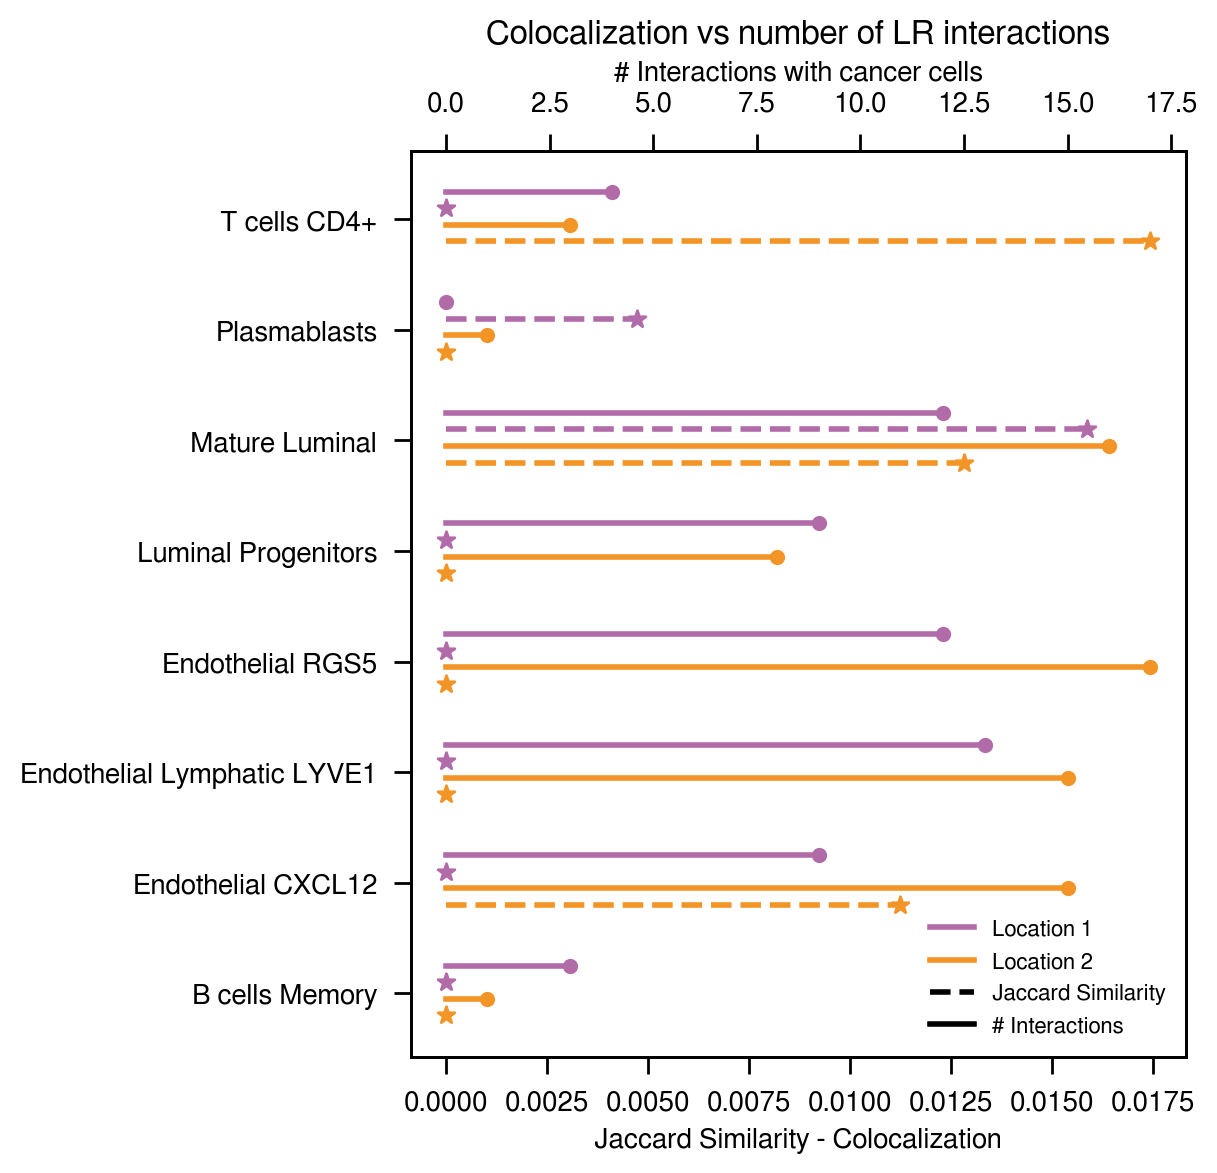

In [22]:
data = data_cc_coloc

# Create the plot
fig, ax = plt.subplots(figsize=(5,6), dpi=200)


# Plot the jaccard similarities as horizontal lolliplots
for i, row in data.iterrows():

    ax.plot([0, row['JS_loc2']], [i, i], color='#F39426', lw=2, ls = '--', zorder=10)
    ax.scatter([row['JS_loc2']], [i], color='#F39426', s=40, marker='*', zorder=10)

    ax.plot([0, row['JS_loc1']], [i + 0.3, i + 0.3], color='#B16BA8', lw=2, ls = '--', zorder=10)
    ax.scatter([row['JS_loc1']], [i + 0.3], color='#B16BA8', s=40,  marker='*', zorder=10)
    
# Create a second x-axis to represent the interactions with cancer cells
ax2 = ax.twiny() 

# Plot the number of significant LR interctions as horizontal lolliplots
for i, row in data.iterrows():
    ax2.plot([0, row['Cancer_loc2']], [i + 0.15, i + 0.15], color='#F39426', lw=2, zorder=10)
    ax2.scatter([row['Cancer_loc2']], [i + 0.15], color='#F39426', s=20, zorder=10)

    ax2.plot([0, row['Cancer_loc1']], [i + 0.45, i + 0.45], color='#B16BA8', lw=2, zorder=10)
    ax2.scatter([row['Cancer_loc1']], [i + 0.45], color='#B16BA8', s=20, zorder=10)
    

ax.set_yticks([0.2, 1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2], data['cells'], fontsize = labelout_size)


ax.set_xlabel('Jaccard Similarity - Colocalization',  fontsize=labelout_size)
ax2.set_xlabel('# Interactions with cancer cells',  fontsize=labelout_size)

ax.tick_params(axis='both', labelsize=labelout_size)



legend_elements = [
    Line2D([0], [0], color='#B16BA8', lw=2, label='Location 1'),
    Line2D([0], [0], color='#F39426', lw=2, label='Location 2'),
    Line2D([0], [0], color='black', lw=2, ls='--', label='Jaccard Similarity'),
    Line2D([0], [0], color='black', lw=2, label='# Interactions')
]
ax.legend(handles=legend_elements, fontsize=label_size, frameon = False, loc = 'lower right')
ax.set_title('Colocalization vs number of LR interactions', fontsize=title_size, y = 1.1)



This plot show the disagreement between the cells that are in similar regions of the spots and the number of predicted LR interactions between them. There are some cases, for example with Endothelial RGS5 or Endothelial Lymphatic LYVE1, that cancer cells never colocalize but the LR interactions counts are high, but also we can see some agreements as in the case of B cells memory where there is no correlation and also the number of interactions is very low. 

# Figure 1 F: Correlation between colocalization and CCC

Finally, we will compute the correlation between the most colocalizated cells with cancer cells and the most interacting cells, to see if we see any relationship. 

In [23]:
## Merge the two result dataframes dataframes
data_correlation = counts_qcell.merge(closest_cells_df, left_index = True, right_on = 'cells')
data_correlation.set_index('cells', inplace = True)
data_correlation.columns = ['Cancer_loc1', 'Cancer_loc2', 'JS_loc1', 'JS_loc2']
data_correlation = data_correlation.astype(float)


Text(0.5, 1.0, 'Correlation between colocalization \n and number of LR interactions')

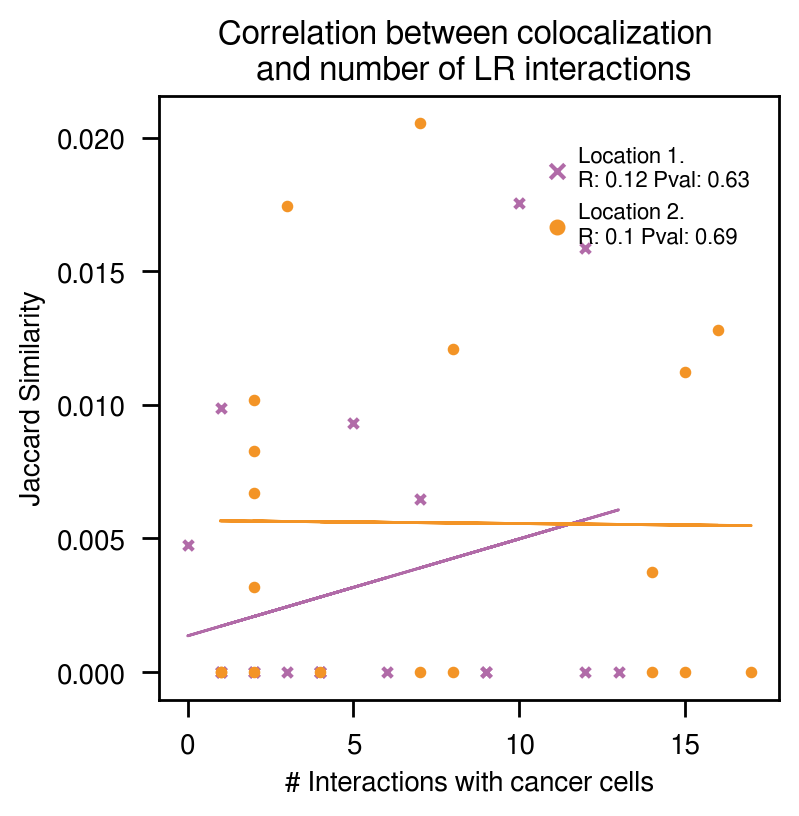

In [24]:
fig, axs = plt.subplots(1, figsize=(4, 4), dpi=200)

axs.scatter(data_correlation['Cancer_loc1'], data_correlation['JS_loc1'], c = '#B16BA8', s = 12, marker='x', label='Location 1. \nR: %s Pval: %s' % (round(spearmanr(data_correlation['Cancer_loc1'], data_correlation['JS_loc1'])[0], 2), round(spearmanr(data_correlation['Cancer_loc1'], data_correlation['JS_loc1'])[1], 2)))
axs.scatter(data_correlation['Cancer_loc2'], data_correlation['JS_loc2'], c ='#F39426', s=10 , label='Location 2. \nR: %s Pval: %s' % (round(spearmanr(data_correlation['Cancer_loc2'], data_correlation['JS_loc2'])[0], 2), round(spearmanr(data_correlation['Cancer_loc2'], data_correlation['JS_loc2'])[1], 2)))
# Calculate and plot regression line for 'Cancer_loc1' vs. 'JS_loc1'
m_red, b_red = np.polyfit(data_correlation['Cancer_loc1'], data_correlation['JS_loc1'], 1)
axs.plot(data_correlation['Cancer_loc1'], m_red * data_correlation['Cancer_loc1'] + b_red, color='#B16BA8', linewidth=1)
# Calculate and plot regression line for 'Cancer_loc2' vs. 'JS_loc2'
m_orange, b_orange = np.polyfit(data_correlation['Cancer_loc2'], data_correlation['JS_loc2'], 1)
axs.plot(data_correlation['Cancer_loc2'], m_orange * data_correlation['Cancer_loc2'] + b_orange, color='#F39426', linewidth=1)

plt.ylabel('Jaccard Similarity', fontsize=labelout_size)
plt.xlabel('# Interactions with cancer cells', fontsize=labelout_size)
plt.tick_params(axis='both', which='major', labelsize=labelout_size)
plt.legend(frameon = False, fontsize = label_size, loc = 'upper left', markerscale=1.5,handlelength=0.5,  handletextpad=0.7, bbox_to_anchor=(0.6, 0.95))
plt.title('Correlation between colocalization \n and number of LR interactions', fontsize=title_size)



# join  plot

No DEGs


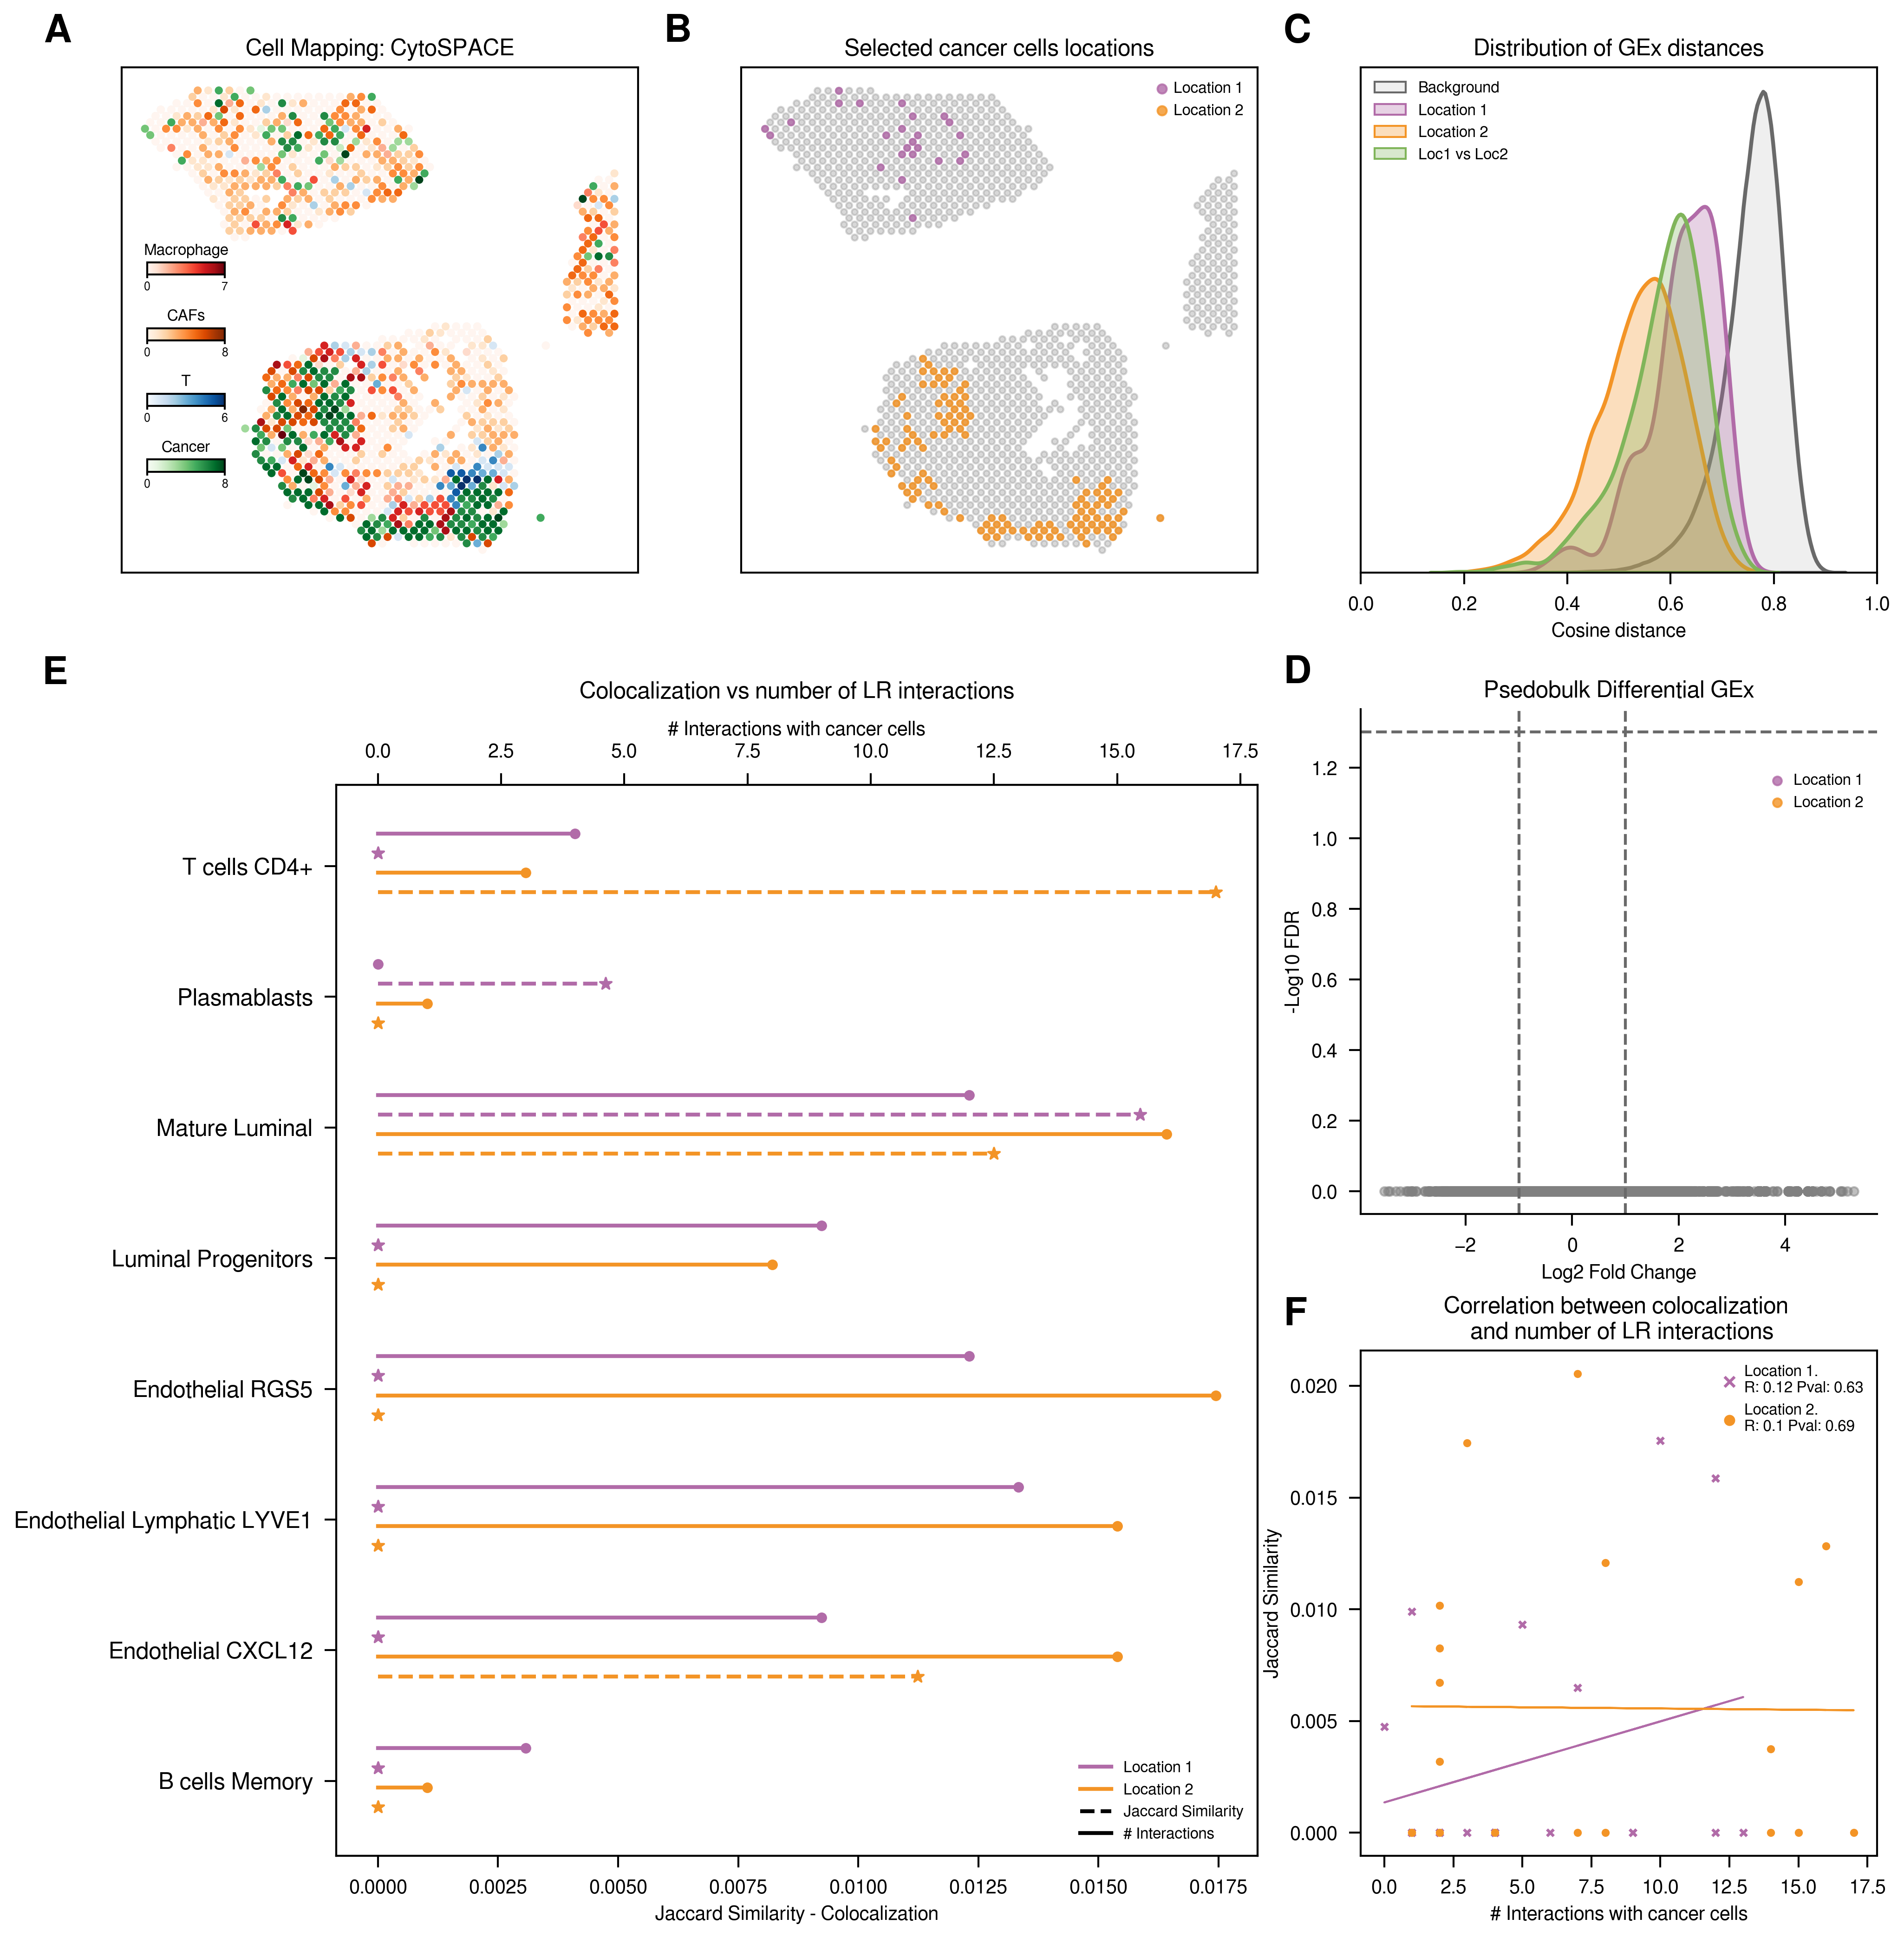

In [25]:
# Create a new figure with a custom grid for subplots
fig2 = plt.figure(figsize=(22, 17), dpi=300)

# Create a GridSpec with an uneven layout
gs2 = gridspec.GridSpec(3, 4, figure=fig2, hspace=0.27)

# First row - 3 plots
ax1 = fig2.add_subplot(gs2[0, :1]) # Span 1 column
ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, size=20, weight='bold')
ax2 = fig2.add_subplot(gs2[0, 1:2]) # Span 1 column
ax2.text(-0.15, 1.05, 'B', transform=ax2.transAxes, size=20, weight='bold')
ax3 = fig2.add_subplot(gs2[0, 2:3]) # Span 2 columns
ax3.text(-0.15, 1.05, 'C', transform=ax3.transAxes, size=20, weight='bold')


# Second row - 1 tall plot and 2 plots one on top of the other
ax4 = fig2.add_subplot(gs2[1:, :2]) # Span 2 rows and 2 columns for the tall plot
ax4.text(-0.319, 1.0938, 'E', transform=ax4.transAxes, size=20, weight='bold')
ax5 = fig2.add_subplot(gs2[1, 2:3]) # Span 2 columns for the top small plot
ax5.text(-0.15, 1.05, 'D', transform=ax5.transAxes, size=20, weight='bold')
ax6 = fig2.add_subplot(gs2[2, 2:3]) # Span 2 columns for the bottom small plot
ax6.text(-0.15, 1.05, 'F', transform=ax6.transAxes, size=20, weight='bold')

#####################################################################################################################################################
#####################################################################################################################################################
####################### MAPPING #####################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################

abundances_figure(abundances, coords, ax1, query_cells, 'Cell Mapping: CytoSPACE', colorbar = True, colorbar_bounds = colorbar_bounds)

#####################################################################################################################################################
#####################################################################################################################################################
####################### DISTANCES ###################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################

sns.kdeplot(all_cosine, label = 'Background', color = 'dimgray', ax = ax3, fill=True, alpha=.1,  linewidth=2)
sns.kdeplot(loc1_cosine, label = 'Location 1', color = '#B16BA8' ,ax = ax3, fill=True, alpha=.3, linewidth=2)
sns.kdeplot(loc2_cosine, label = 'Location 2', color = '#F39426', ax = ax3, fill=True,  alpha=.3,linewidth=2)
sns.kdeplot(np.concatenate(vs_cosine), label = 'Loc1 vs Loc2', color = '#80b55a', fill=True, alpha = 0.3,linewidth=2, ax=ax3)


legend = ax3.legend(frameon = False, fontsize = label_size, loc= 'upper left')
for handle in legend.legend_handles:
    handle.set_linewidth(1) 

ax3.set_xlim(0,1)
ax3.set_xlabel('Cosine distance', fontsize=labelout_size)
ax3.set_ylabel('')
ax3.set_yticks([])
ax3.tick_params(axis='both', which='major', labelsize=labelout_size)
ax3.set_title('Distribution of GEx distances', fontsize=title_size)

#####################################################################################################################################################
#####################################################################################################################################################
####################### VOLCANO #####################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################

ax5.scatter(log_fold_changes, neg_log_p_values, color='grey', alpha=0.5, s = 20)
ax5.scatter(log_fold_changes[(log_fold_changes > 1) & (neg_log_p_values > -np.log10(0.05))], 
            neg_log_p_values[(log_fold_changes > 1) & (neg_log_p_values > -np.log10(0.05))], 
            color='#B16BA8', alpha=0.8, s= 20, label = 'Location 1')
ax5.scatter(log_fold_changes[(log_fold_changes < -1) & (neg_log_p_values > -np.log10(0.05))], 
            neg_log_p_values[(log_fold_changes < -1) & (neg_log_p_values > -np.log10(0.05))], 
            color='#F39426', alpha=0.8, s= 20 , label = 'Location 2')

texts = []
for index, row in top_pval.iterrows():
        texts.append(ax5.text(row['log2FoldChange'], -np.log10(row['padj']), row['index'], fontsize=label_size, fontweight = 'bold'))

for index, row in top_all.iterrows():
        if row['padj'] > 0.05:
                continue 
        if row['index'] not in top_pval['index'].tolist():
                texts.append(ax5.text(row['log2FoldChange'], -np.log10(row['padj']), row['index'], fontsize=label_size, fontweight = 'bold'))

try:
    adjust_text(texts, ax=ax5)
except:
    print('No DEGs')


# Highlighting the threshold line for p-value
ax5.axhline(y=-np.log10(0.05), color='dimgray', linestyle='--')
ax5.axvline(x=1, color='dimgray', linestyle='--')
ax5.axvline(x=-1, color='dimgray', linestyle='--')


# Add labels and title
ax5.set_xlabel('Log2 Fold Change', fontsize=labelout_size)
ax5.set_ylabel('-Log10 FDR', fontsize=labelout_size)
ax5.set_title('Psedobulk Differential GEx', fontsize=title_size)

ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)

ax5.tick_params(axis='both', which='major', labelsize=labelout_size)
ax5.legend(frameon = False, fontsize = label_size, handlelength=0.5, loc = 'upper right', bbox_to_anchor=(1, 0.9))

#####################################################################################################################################################
#####################################################################################################################################################
####################### INTERACTIONS ################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################


# Plot the jaccard similarities as horizontal lolliplots
for i, row in data.iterrows():

    ax4.plot([0, row['JS_loc2']], [i, i], color='#F39426', lw=2, ls = '--', zorder=10)
    ax4.scatter([row['JS_loc2']], [i], color='#F39426', s=40, marker='*', zorder=10)

    ax4.plot([0, row['JS_loc1']], [i + 0.3, i + 0.3], color='#B16BA8', lw=2, ls = '--', zorder=10)
    ax4.scatter([row['JS_loc1']], [i + 0.3], color='#B16BA8', s=40,  marker='*', zorder=10)
    
# Create a second x-axis to represent the interactions with cancer cells
ax42 = ax4.twiny() 

# Plot the number of significant LR interctions as horizontal lolliplots
for i, row in data.iterrows():
    ax42.plot([0, row['Cancer_loc2']], [i + 0.15, i + 0.15], color='#F39426', lw=2, zorder=10)
    ax42.scatter([row['Cancer_loc2']], [i + 0.15], color='#F39426', s=20, zorder=10)

    ax42.plot([0, row['Cancer_loc1']], [i + 0.45, i + 0.45], color='#B16BA8', lw=2, zorder=10)
    ax42.scatter([row['Cancer_loc1']], [i + 0.45], color='#B16BA8', s=20, zorder=10)
    

ax4.set_xlabel('Jaccard Similarity - Colocalization',  fontsize=labelout_size)
ax42.set_xlabel('# Interactions with cancer cells',  fontsize=labelout_size)

ax4.tick_params(axis='both', labelsize=labelout_size)
ax4.set_yticks([0.2, 1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.2], data['cells'], fontsize = title_size)
ax4.set_title('Colocalization vs number of LR interactions', fontsize=title_size, y = 1.07)

legend_elements = [
    Line2D([0], [0], color='#B16BA8', lw=2, label='Location 1'),
    Line2D([0], [0], color='#F39426', lw=2, label='Location 2'),
    Line2D([0], [0], color='black', lw=2, ls='--', label='Jaccard Similarity'),
    Line2D([0], [0], color='black', lw=2, label='# Interactions')
]
ax4.legend(handles=legend_elements, fontsize=label_size, frameon = False, loc = 'lower right')

pos = ax4.get_position()
pos.x0 = pos.x0 + 0.07
pos.y1 = pos.y1 - 0.032
ax4.set_position(pos)


#####################################################################################################################################################
#####################################################################################################################################################
####################### LOCATION ####################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################

background_coords = cyto_cell2spot.drop_duplicates('SpotID')[['SpotID', 'row', 'col']]

xs_b = background_coords.row.values
ys_b = background_coords.col.values

xl = cyto_cell2spot[cyto_cell2spot.SpotID.isin(loc2_spots)].drop_duplicates('SpotID')[['SpotID', 'row', 'col']].row.values
yl = cyto_cell2spot[cyto_cell2spot.SpotID.isin(loc2_spots)].drop_duplicates('SpotID')[['SpotID', 'row', 'col']].col.values

xr = cyto_cell2spot[cyto_cell2spot.SpotID.isin(loc1_spots)].drop_duplicates('SpotID')[['SpotID', 'row', 'col']].row.values
yr = cyto_cell2spot[cyto_cell2spot.SpotID.isin(loc1_spots)].drop_duplicates('SpotID')[['SpotID', 'row', 'col']].col.values

ax2.scatter(ys_b, -xs_b, s=10, c = 'grey', alpha = 0.3)
ax2.scatter(yr, -xr, s=10, c = '#B16BA8', alpha = 0.8, label = 'Location 1')
ax2.scatter(yl, -xl, s=10, c = '#F39426', alpha = 0.8, label = 'Location 2')
ax2.set_title('Selected cancer cells locations', fontsize=title_size)
ax2.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
ax2.legend(frameon = False,  markerscale=1.5,handlelength=0.5,  handletextpad=0.5, fontsize = label_size, loc = 'upper right')


#####################################################################################################################################################
#####################################################################################################################################################
####################### CORRELATION #################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################

ax6.scatter(data_correlation['Cancer_loc1'], data_correlation['JS_loc1'], c = '#B16BA8', s = 12, marker='x', label='Location 1. \nR: %s Pval: %s' % (round(spearmanr(data_correlation['Cancer_loc1'], data_correlation['JS_loc1'])[0], 2), round(spearmanr(data_correlation['Cancer_loc1'], data_correlation['JS_loc1'])[1], 2)))
ax6.scatter(data_correlation['Cancer_loc2'], data_correlation['JS_loc2'], c ='#F39426', s=10 , label='Location 2. \nR: %s Pval: %s' % (round(spearmanr(data_correlation['Cancer_loc2'], data_correlation['JS_loc2'])[0], 2), round(spearmanr(data_correlation['Cancer_loc2'], data_correlation['JS_loc2'])[1], 2)))
# Calculate and plot regression line for 'Cancer_loc1' vs. 'JS_loc1'
m_red, b_red = np.polyfit(data_correlation['Cancer_loc1'], data_correlation['JS_loc1'], 1)
ax6.plot(data_correlation['Cancer_loc1'], m_red * data_correlation['Cancer_loc1'] + b_red, color='#B16BA8', linewidth=1)
# Calculate and plot regression line for 'Cancer_loc2' vs. 'JS_loc2'
m_orange, b_orange = np.polyfit(data_correlation['Cancer_loc2'], data_correlation['JS_loc2'], 1)
ax6.plot(data_correlation['Cancer_loc2'], m_orange * data_correlation['Cancer_loc2'] + b_orange, color='#F39426', linewidth=1)

ax6.set_ylabel('Jaccard Similarity', fontsize=labelout_size)
ax6.set_xlabel('# Interactions with cancer cells', fontsize=labelout_size)
ax6.tick_params(axis='both', which='major', labelsize=labelout_size)
ax6.legend(frameon = False, fontsize = label_size, loc = 'upper right', markerscale=1.5,handlelength=0.5,  handletextpad=0.7)
ax6.set_title('Correlation between colocalization \n and number of LR interactions', fontsize=title_size)
plt.savefig(global_path + 'grid_figure_'+patient+'.svg',format='svg', dpi=300)
plt.savefig(global_path + 'grid_figure_'+patient+'.png',format='png', dpi=300, facecolor='white', edgecolor='none')
plt.show()